In [3]:
import os
import sys

# Scientific computation
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import konlpy

from sklearn.metrics import accuracy_score
import re
import sklearn
import seaborn as sns

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.plotting.register_matplotlib_converters()
import folium

# Font detection
import matplotlib.font_manager as fm
from fontTools.ttLib import TTFont
fm._rebuild()

# Eye candy
from tqdm import tqdm

print(sys.version)
for m in [np, sp, pd, xgb, lgb, konlpy, mpl, folium]:
    print(f'{m.__name__}: {m.__version__}')

print(f"Current Environment: {os.environ['CONDA_DEFAULT_ENV']}")
# assert os.environ['CONDA_DEFAULT_ENV'] == 'nims-academy-2019-08'

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy: 1.16.4
scipy: 1.3.0
pandas: 0.24.2
xgboost: 0.90
lightgbm: 2.2.1
konlpy: 0.5.1
matplotlib: 3.1.0
folium: 0.10.0
Current Environment: base


# load data

In [4]:
path = os.getcwd()
diabetes = pd.read_csv(path+'/data/diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Check Data

In [3]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- Glucose	
- BloodPressure
- SkinThickness
- Insulin 
- BMI

has Nan data

# Replace 0 to nan

In [4]:
diabetes['Glucose'] = diabetes.Glucose.replace(0, np.nan)
diabetes['BloodPressure'] = diabetes.BloodPressure.replace(0, np.nan)
diabetes['SkinThickness'] = diabetes.SkinThickness.replace(0, np.nan)
diabetes['Insulin'] = diabetes.Insulin.replace(0, np.nan)
diabetes['BMI'] = diabetes.BMI.replace(0, np.nan)

# Count nan in data

In [5]:
total = diabetes.isnull().sum().sort_values(ascending=False)
total

Insulin                     374
SkinThickness               227
BloodPressure                35
BMI                          11
Glucose                       5
Outcome                       0
Age                           0
DiabetesPedigreeFunction      0
Pregnancies                   0
dtype: int64

# Check Missing Value

In [6]:
#histogram
#missing_data = missing_data.head(20)

#missing data
percent = (diabetes.isnull().sum()/diabetes.isnull().count()).sort_values(ascending=False)
percent

Insulin                     0.486979
SkinThickness               0.295573
BloodPressure               0.045573
BMI                         0.014323
Glucose                     0.006510
Outcome                     0.000000
Age                         0.000000
DiabetesPedigreeFunction    0.000000
Pregnancies                 0.000000
dtype: float64

In [7]:
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Insulin,374,0.486979
SkinThickness,227,0.295573
BloodPressure,35,0.045573
BMI,11,0.014323
Glucose,5,0.006510
Outcome,0,0.000000
Age,0,0.000000
DiabetesPedigreeFunction,0,0.000000
Pregnancies,0,0.000000


Text(0.5, 1.0, '[CHART1]Total Missing Value (%)')

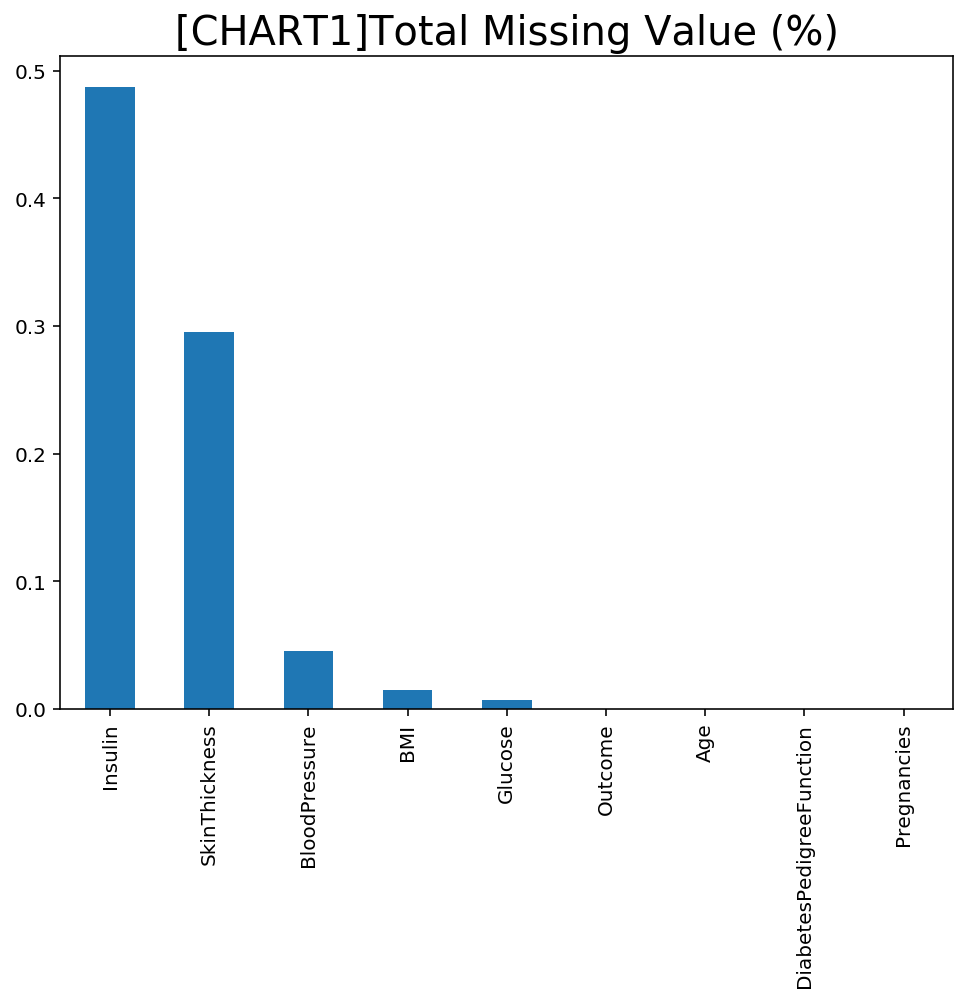

In [51]:
# percent_data = percent.head(20)
percent.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("[CHART1]Total Missing Value (%)", fontsize = 20)

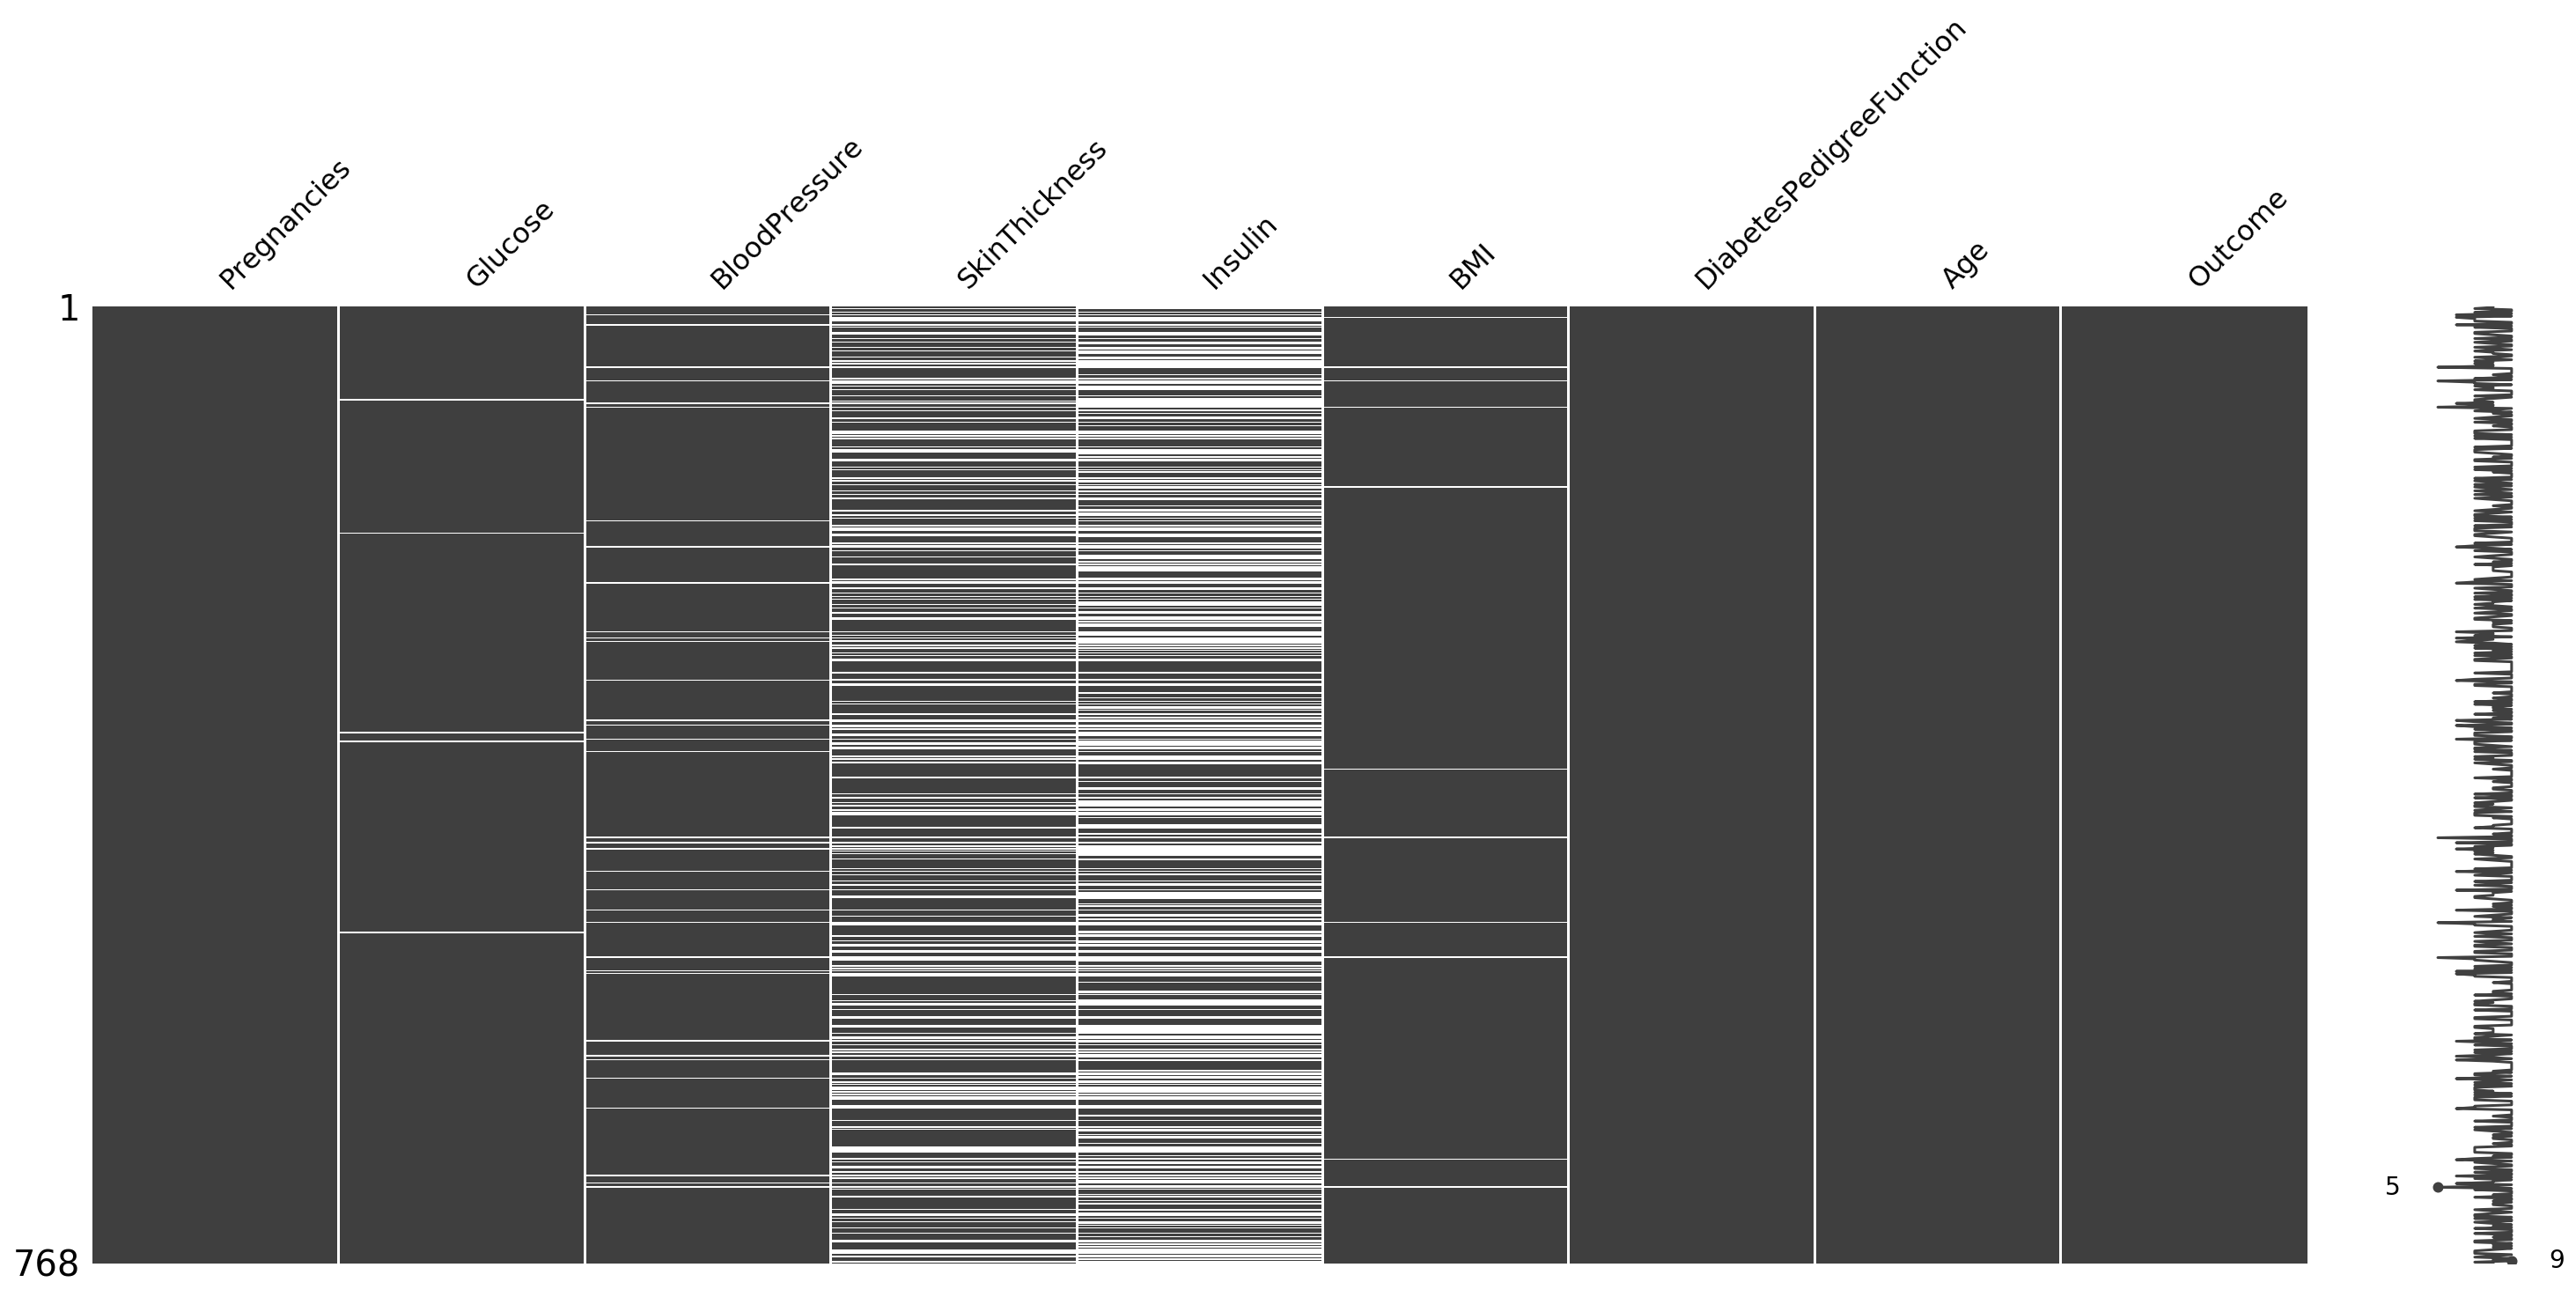

In [10]:
import missingno as msno

msno.matrix(diabetes)
plt.show()

In [11]:
# import missingno as msno
# missingdata_df = diabetes.columns[diabetes.isnull().any()].tolist()
# msno.heatmap(diabetes[missingdata_df], figsize=(8,6))
# plt.title("Correlation with Missing Values", fontsize = 20)

- [CHART1]을 통해 BloodPressure, BMI, Glucose의 경우 결측치의 비율이 굉장히 낮음을 확인할 수 있다.
- [CHART1]을 통해 skinthickness와 insulin의 경우 결측치의 비율이 굉장히 높음을 확인할 수 있다.
- 따라서 위의 3가지 변수의 결측치는 임의적으로 체워도 결과에 큰 영향이 없을 것으로 가정한다.

# 1. BloodPressure, BMI, Glucose
- BloodPressure	35개	0.045573(4%)
- BMI	11개	0.014323(1%)
- Glucose	5개	0.006510(0.6%)

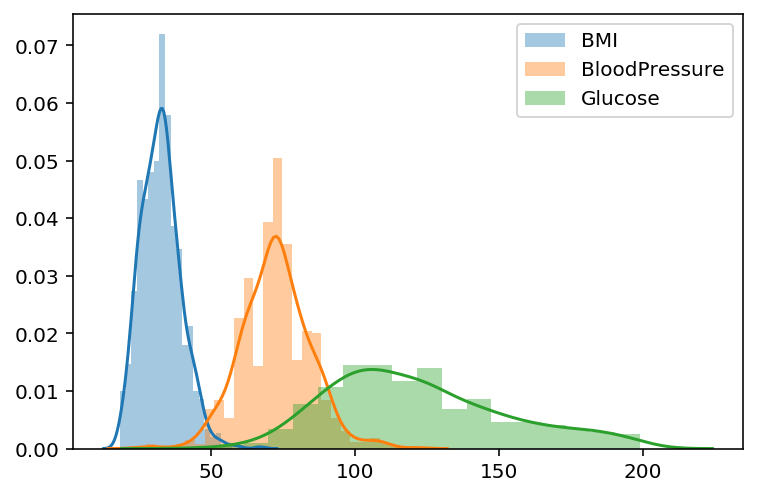

In [39]:
plt.subplot()
sns.distplot(diabetes['BMI'])
sns.distplot(diabetes['BloodPressure'])
sns.distplot(diabetes['Glucose'])
plt.legend(['BMI','BloodPressure','Glucose'])
plt.xlabel("")
plt.ylabel("")
plt.show()

In [41]:
list = missing_data['Percent'].iloc[2:5]
BP = list[0]
BMI = list[1]
Glucose = list[2]
print("BMI= %f \nSo I fill them mean : %f\n" %(BMI,diabetes.BMI.mean())) # distribution을 그렸을 때, 정규분포 모양을 안따름
print("BloodPressure= %f \nSo I fill them mod : 100 \n" %BP) # distribution을 그렸을 때, 정규분포 모양을 안따름
print("Glucose= %f \nSo I fill them mean : %f\n" %(Glucose,diabetes.Glucose.mean())) # distribution을 그렸을 때, 정규분포 모양을 안따름

# 최대한 데이터에 영향을 주지 않게 NaN 값을 할당함

BMI= 0.014323 
So I fill them mean : 32.457464

BloodPressure= 0.045573 
So I fill them mod : 100 

Glucose= 0.006510 
So I fill them mean : 121.545573



In [42]:
diabetes.Glucose = diabetes.Glucose.fillna(100) #mod = 99 and 100 so we choose 100
diabetes.BMI = diabetes.BMI.fillna(diabetes.BMI.mean())
diabetes.BloodPressure = diabetes.BloodPressure.fillna(diabetes.BloodPressure.mean())
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


# Check after filling small Nan

In [43]:
total_new = diabetes.isnull().sum().sort_values(ascending=False)
total_new

Insulin                     374
SkinThickness               227
Outcome                       0
Age                           0
DiabetesPedigreeFunction      0
BMI                           0
BloodPressure                 0
Glucose                       0
Pregnancies                   0
dtype: int64

In [44]:
percent_new = (diabetes.isnull().sum()/diabetes.isnull().count()).sort_values(ascending=False)
percent_new

Insulin                     0.486979
SkinThickness               0.295573
Outcome                     0.000000
Age                         0.000000
DiabetesPedigreeFunction    0.000000
BMI                         0.000000
BloodPressure               0.000000
Glucose                     0.000000
Pregnancies                 0.000000
dtype: float64

In [45]:
missing_data_new = pd.concat([total_new, percent_new], axis=1, keys=['Total', 'Percent'])
missing_data_new

,Total,Percent
Insulin,374,0.486979
SkinThickness,227,0.295573
Outcome,0,0.000000
Age,0,0.000000
DiabetesPedigreeFunction,0,0.000000
BMI,0,0.000000
BloodPressure,0,0.000000
Glucose,0,0.000000
Pregnancies,0,0.000000


Text(0.5, 1.0, '[chart2]Total Missing Value (%)')

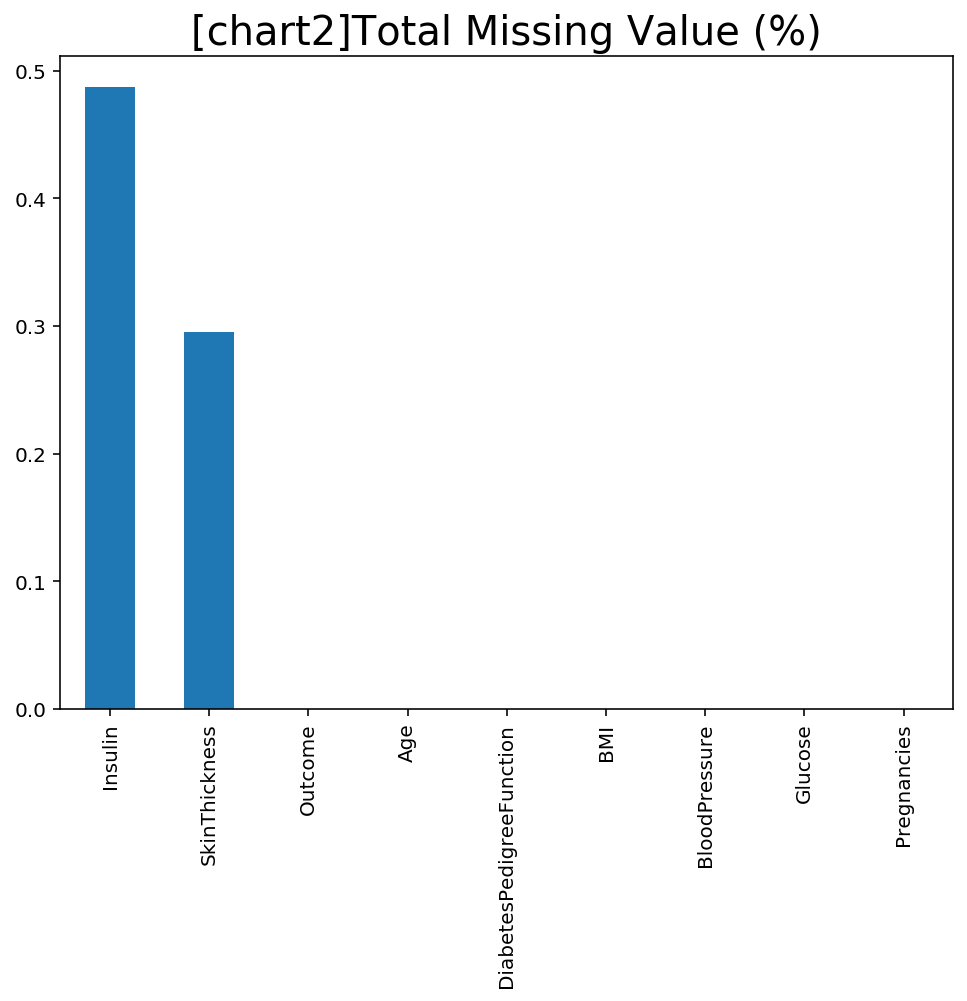

In [50]:
# percent_data = percent.head(20)
percent_new.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("[chart2]Total Missing Value (%)", fontsize = 20)

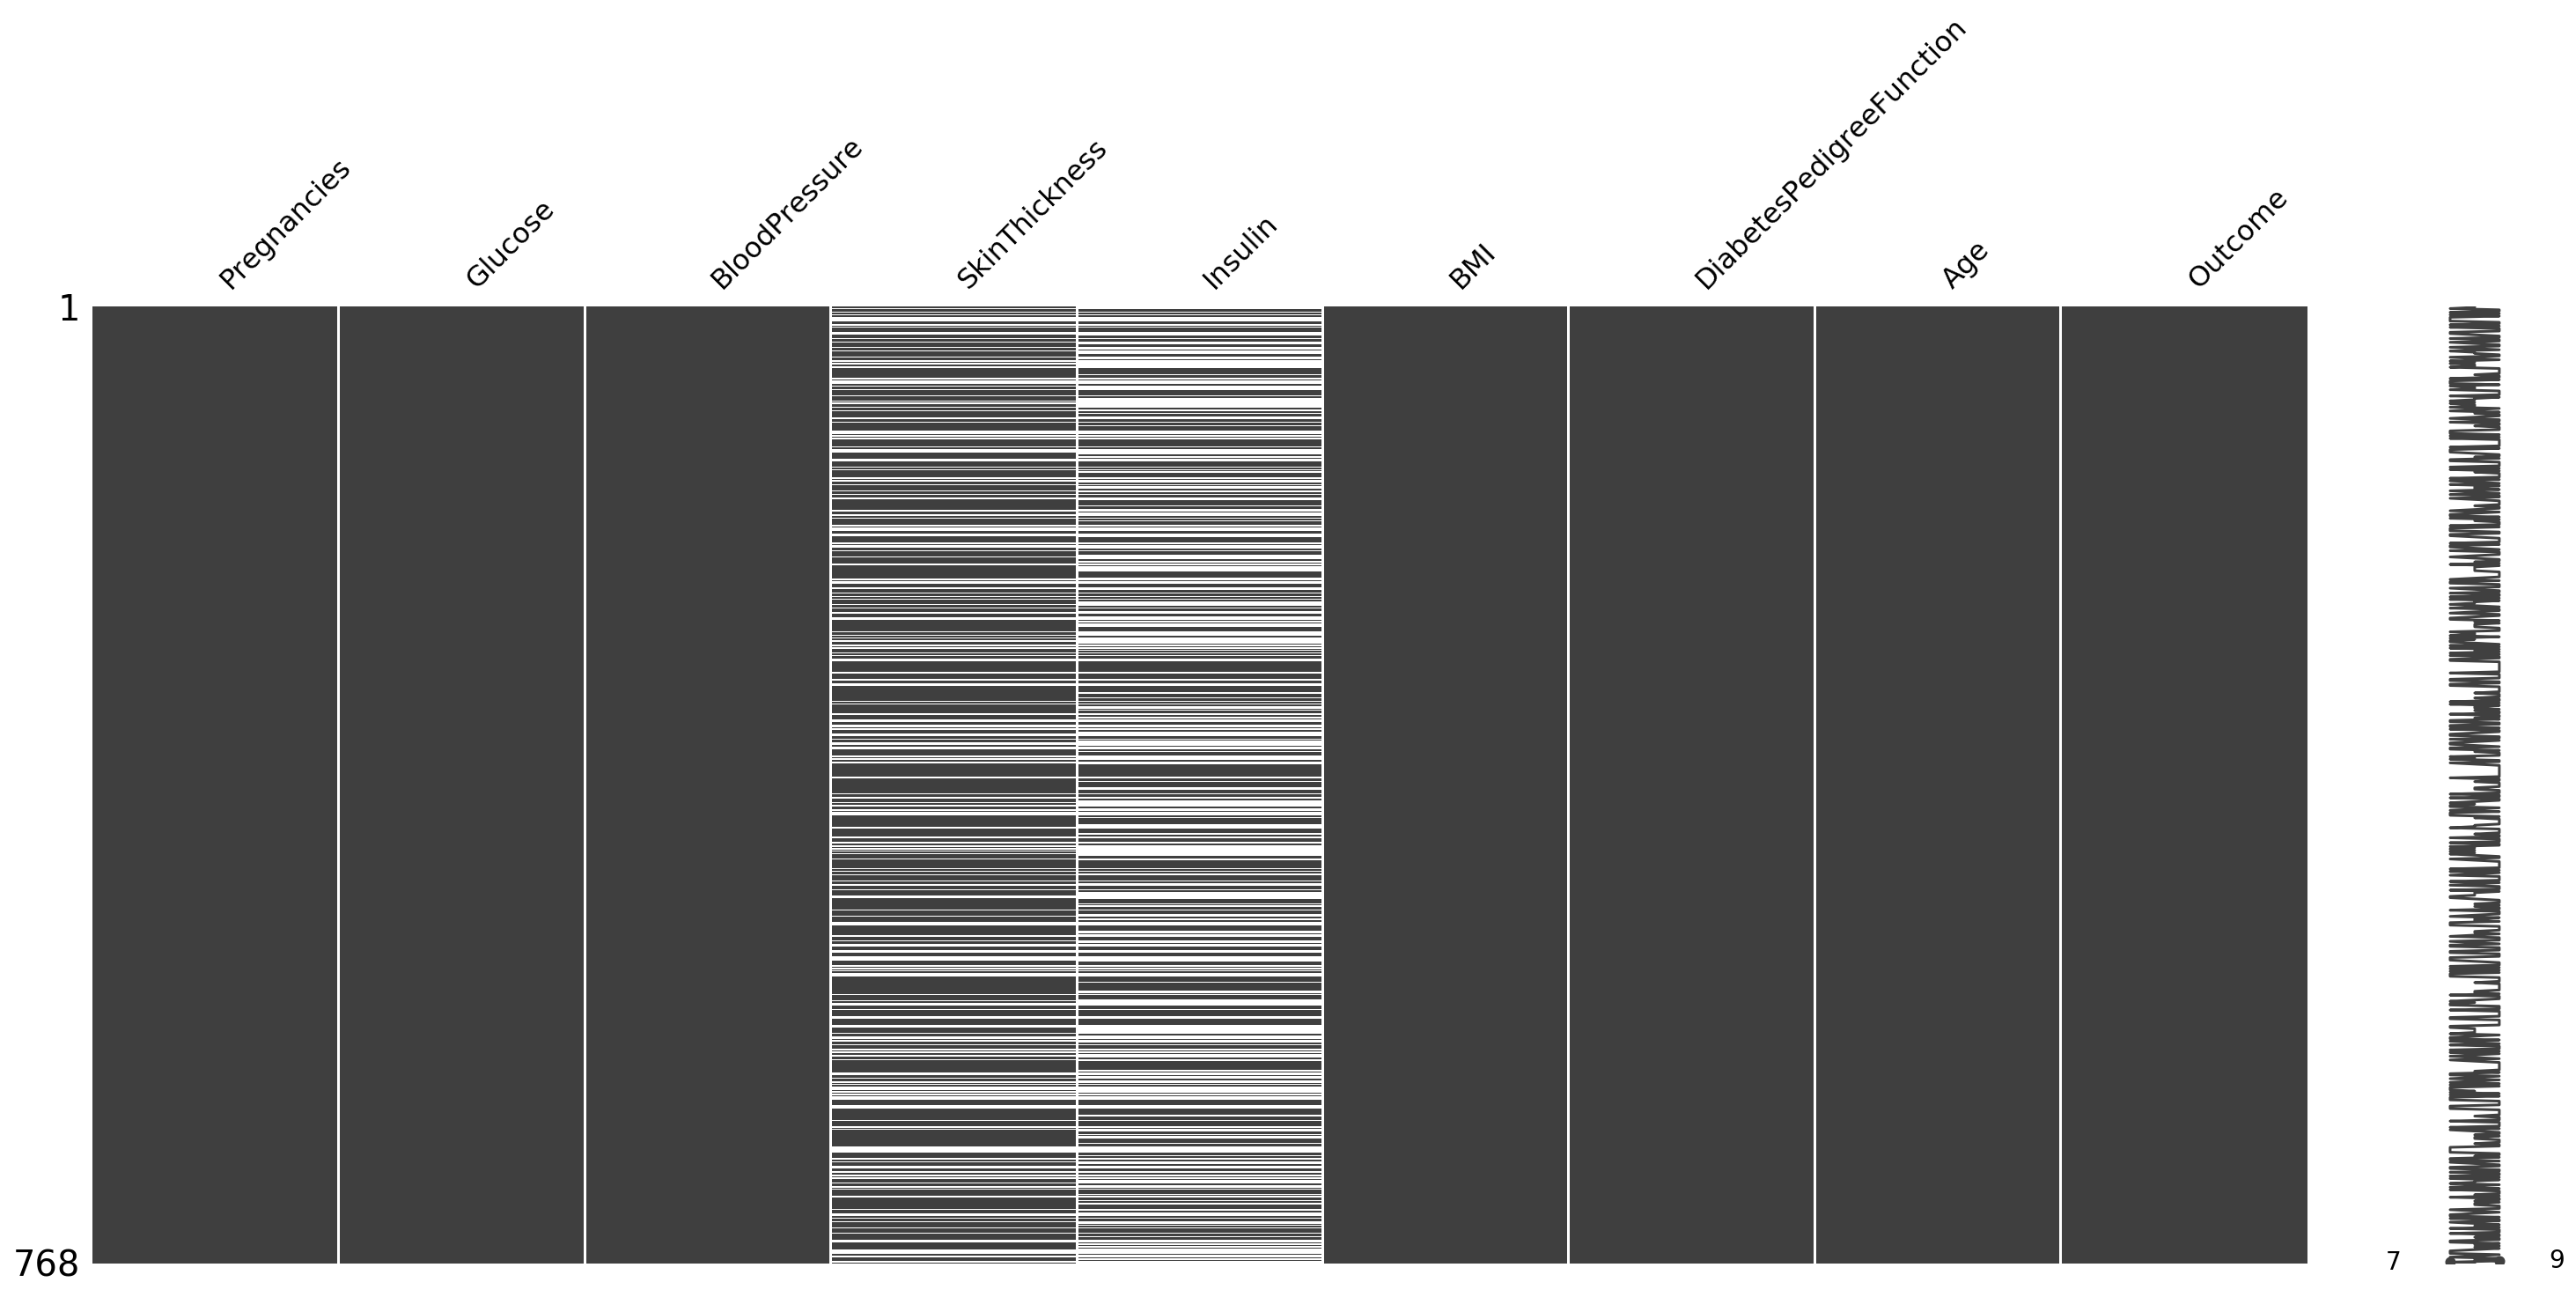

In [47]:
# import missingno as msno

msno.matrix(diabetes)
plt.show()

# Big Nan
- [CHART2]을 통해 BloodPressure, BMI, Glucose의 경우 결측치의 비율이 굉장히 낮음을 확인할 수 있다.
- [CHART2]을 통해 skinthickness와 insulin의 경우 결측치의 비율이 굉장히 높음을 확인할 수 있다.
skinthickness와 insulin은 결측치의 비율이 굉장히 커서 위의 방식과 같이 임의적으로 처리할 수 없다.

# 2. Insulin, SkinThickness
- Insulin	374개	0.486979(49%)
- SkinThickness	227개	0.295573(30%)

## 결측 데이터의 종류
이유
 - 완전 무작위 결측(MCAR) : 다른 변수와 상관 없이 발생
			Y가 누락 될 확률은 X 또는 Y와 관련이 없음(independent, corr 없음)
 - 무작위 결측(MAR) : 특정 변수와 관련되어 일어나지만, 그 변수의 결과는 관계가 없는 경우
			Y가 누락 될 확률은 X의 값에'만' 의존
 - 비 무작위 결측(MNAR) : 누락된 값이 다른 변수와 연관 있는 경우
			Y가 누락 될 확률은 Y 자체의 관찰되지 않는 값에 달려 있다.

In [52]:
# diabetes['hasInsulin'] = diabetes['Insulin'].isnull().apply(lambda x: 0 if x == True else 1) 
# diabetes['hasSkinThickness'] = diabetes['SkinThickness'].isnull().apply(lambda x: 0 if x == True else 1)

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [56]:
print("---------------------------------------------------")
print((diabetes.corr().iloc[3:5,:-1]).T)
print("---------------------------------------------------\n")

---------------------------------------------------
                          SkinThickness   Insulin
Pregnancies                    0.100239  0.082171
Glucose                        0.226620  0.581950
BloodPressure                  0.226691  0.098272
SkinThickness                  1.000000  0.184888
Insulin                        0.184888  1.000000
BMI                            0.647932  0.228082
DiabetesPedigreeFunction       0.115016  0.130395
Age                            0.166816  0.220261
---------------------------------------------------



# 해석
Insulin은 NaN이 없는 특징 중에서 Glucose와 강한 상관관계(0.58)를 갖고 다른 특징과는 특별히 상관관계가 없다.

SkinThickness는 NaN이 없는 특징 중에서 BMI와는 강한 상관관계(0.65)를 갖고 다른 특징과는 특별히 상관관계가 없다.

In [61]:
print("------------------------------------------------------")
print(abs(diabetes.corr().iloc[-1:,:-1]).T)
print("------------------------------------------------------\n")

------------------------------------------------------
                           Outcome
Pregnancies               0.221898
Glucose                   0.491623
BloodPressure             0.166074
SkinThickness             0.259491
Insulin                   0.303454
BMI                       0.311924
DiabetesPedigreeFunction  0.173844
Age                       0.238356
------------------------------------------------------



# 결론
1. Insulin는 outcome와 0.3, SkinThickness는 outcome 0.25 정도의 상관관계가 있다. 즉, 두 특징은 결과(Outcome)에 직접적인 영향을 주지는 않는다. 하지만 Glucose, BMI 와 Outcome과의 상관관계를 확인해보면
2. Insulin은 Glucose와 강한 상관관계가 있는데 Glucose는 Outcome과 약0.5의 상관관계를 갖는다.
-> Glucose가 Outcome에 가장 큰 영향을 주므로 Insulin이라는 col을 제거해도 괜찮을 것으로 판단한다.
 -  Insulin이 누락 될 확률은 Insulin 자체의 관찰되지 않는 값(즉, Glucose)에 달려 있다.(MNAR)
 
3. SkinThickness는 BMI와 강한 상관관계가 있는데 BMI는 Outcome과 약0.31의 상관관계를 갖는다.
-> BMI가 Outcome에 두번째로 큰 영향을 주므로 BMI라는 col을 제거해도 괜찮을 것으로 판단한다.
 - 비 무작위 결측(MNAR) : 누락된 값이 다른 변수와 연관 있는 경우
 -  SkinThickness가 누락 될 확률은 SkinThickness 자체의 관찰되지 않는 값(즉, BMI)에 달려 있다.(MNAR)
 
 